In [153]:
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import timedelta
from matplotlib import pyplot as plt

In [202]:
def metrics(test, method: str = "Naive", resid:str = "resid", y: str = "Beer"):
    q = test[resid] / ((1 / (len(test) - 4 + 1)) * (np.sum(np.abs(test[y] - test[y].shift(-4)))))

    m = {"Method": method,
         "MAE": np.round(np.mean(np.abs(test[resid])), 2),
         "RMSE": np.round(np.sqrt(np.mean(test[resid] ** 2)), 2),
         "MAPE": np.round(np.mean(np.abs(100 * test[resid] / test[y])), 2),
         "MASE": np.round(np.mean(np.abs(q)), 2)}

    return pd.DataFrame(m, index=[0])

### 1.0. Evaluate Point Forecast

É importante medir a acurácia das previsões.


Mas, devemos medir essa acurácia em novos dados que o modelo não foi fitado. Uma prática é separar os dados em treino e teste, o conjunto de treino é utilizado para estimar os parâmetros do método de previsão utilizado e o teste é utilizado para avaliar a acurácia.


O tamanho da separação do conjunto de dados de treino e teste varia, geralmente os 20% dos últimos dados disponíveis são utilizados para treino e 80% dos dados iniciais da série para treino.


![image](https://otexts.com/fpp3/fpp_files/figure-html/traintest-1.png)


- Um modelo que fita bem o conjunto de dados, não necessariamente fará boas previsões.
- Um modelo perfeito pode sim ser obtido dependendo do modelo e das características da série.
- Over-fitting é justamente falhar em identificar padrões sistemáticos na série.


#### 1.1. Aus Production

In [78]:
df = pd.read_csv("../data/aus_production.csv", index_col=[0])
df['Quarter'] = df.Quarter.apply(lambda x: x.replace(' ', '-'))
df['Quarter'] = pd.PeriodIndex(df.Quarter, freq='Q').to_timestamp()

# Recent Production filtering
df = df[df["Quarter"] >= "1997-01-01"]

# Train test split
train = df[df["Quarter"] < "2008-01-01"].reset_index(drop=True)
test = df[df["Quarter"] >= "2008-01-01"].reset_index(drop=True)

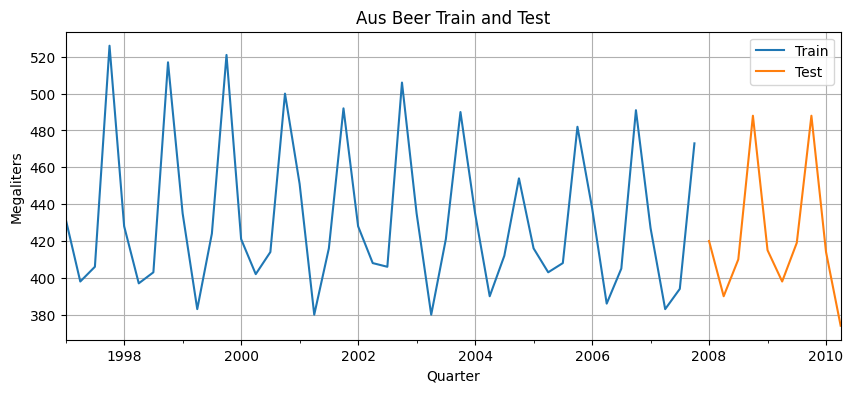

In [79]:
ax = train.plot(
    x="Quarter", y="Beer", figsize=(10, 4),
    label="Train", ylabel="Megaliters",
    title="Aus Beer Train and Test"
)
test.plot(
    x="Quarter", y="Beer",
    ax=ax, grid=2, label="Test"
);

In [80]:
seasonal_naive = train.tail(4)["Beer"].to_list()

seasonal_naive = (1 + (test.Quarter.nunique() // 4)) * seasonal_naive

test["SeasonalNaive"] = seasonal_naive[:len(test)]

test["Naive"] = [train["Beer"].iloc[-1]] * len(test)

test["Mean"] = [train["Beer"].mean()] * len(test)

In [140]:
df_metrics = pd.DataFrame()
for method in ["SeasonalNaive", "Naive", "Mean"]:
    test["resid"] = test["Beer"] - test[method]
    
    dfr = metrics(test, method=method)

    df_metrics = pd.concat([df_metrics, dfr], axis=0)

df_metrics.reset_index(drop=True, inplace=True)

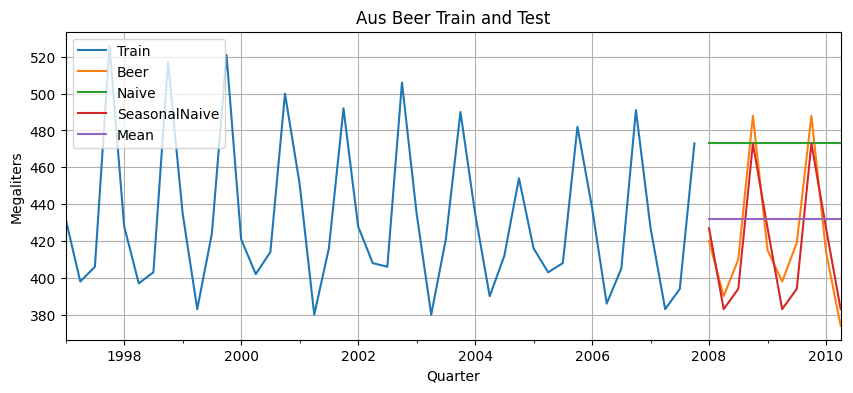

In [81]:
ax = train.plot(
    x="Quarter", y="Beer", figsize=(10, 4),
    label="Train", ylabel="Megaliters",
    title="Aus Beer Train and Test"
)
test[["Quarter", "Beer", "Naive", "SeasonalNaive", "Mean"]].plot(
    x="Quarter",
    ax=ax, grid=2, label="Test"
);

In [139]:
df_metrics

,Method,MAE,RMSE,MAPE,MASE
0,SeasonalNaive,13.40,14.31,3.17,1.71
1,Naive,57.40,62.69,14.18,7.33
2,Mean,32.92,37.43,7.79,4.20


#### 1.2. Time Series Cross Validation

O Cross Validation é um procedimento para treinar e prever múltiplas vezes no mesmo dataset e obter a média e desvio padrão das métricas, é uma forma sofisticada de treinamento e teste.


Onde os dados em azul são o treino e em laranja é o teste.


Existem várias alternativas para esse procedimento:


- One-Step, prever um valor único sendo o próximo da sequência ou um valor a frente da sequência.
- Multi-Step, prever vários valores no futuro.


Na imagem abaixo está um exemplo de "one step".


![image](https://otexts.com/fpp3/fpp_files/figure-html/cv1-1.png)

In [142]:
df = pd.read_csv("../data/gafa_stock.csv", index_col=[0])

df = df[df["Symbol"] == "GOOG"].reset_index(drop=True)

df["Date"] = pd.to_datetime(df["Date"])

df = df[(df["Date"] < "2016-01-01") & (df["Date"] >= "2015-01-01")]

df.reset_index(drop=True, inplace=True)

In [172]:
df["week"] = df["Date"].dt.isocalendar()["week"]

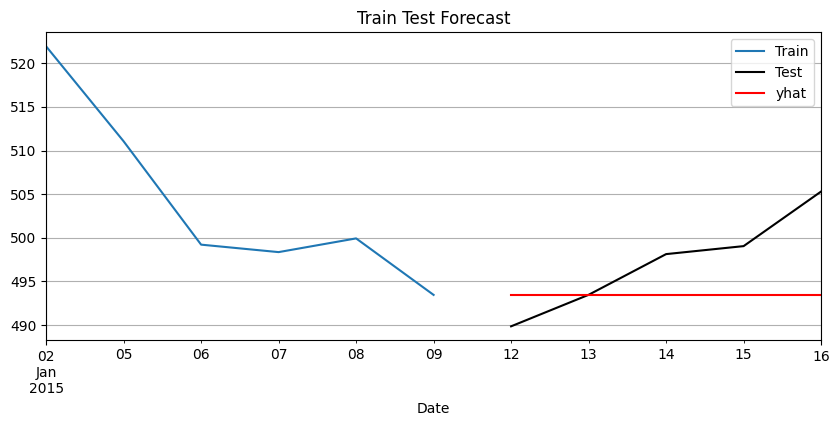

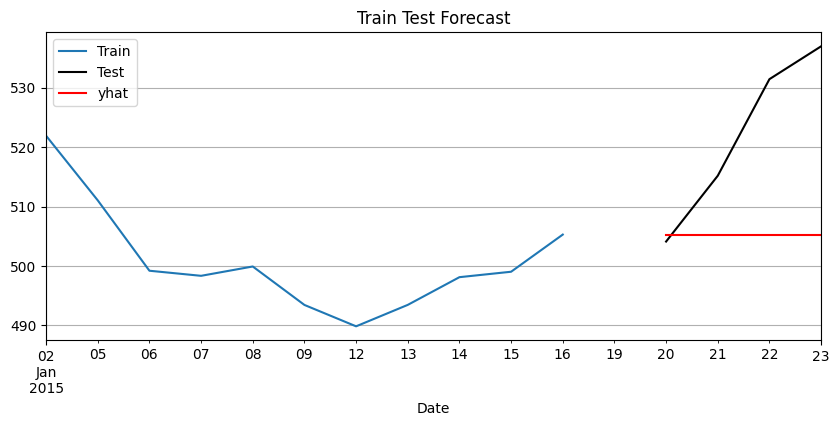

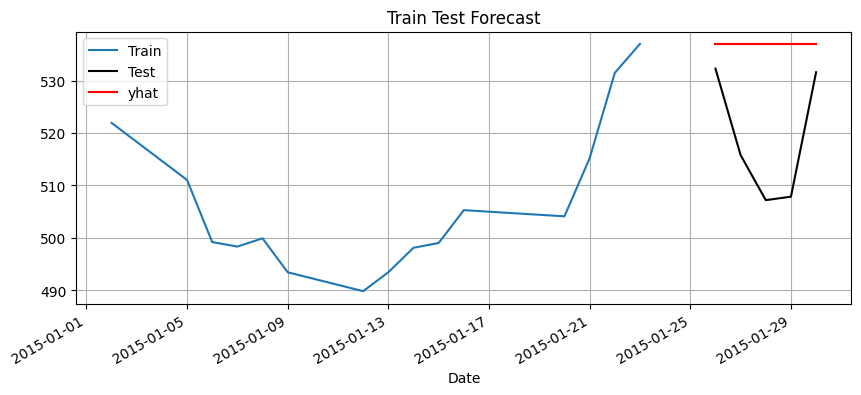

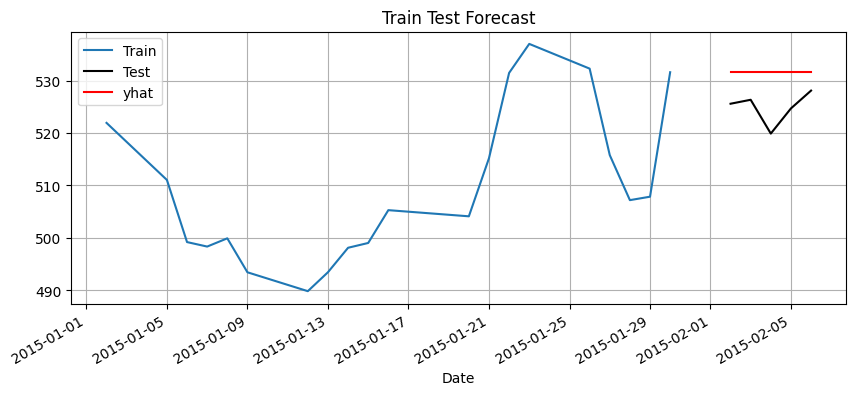

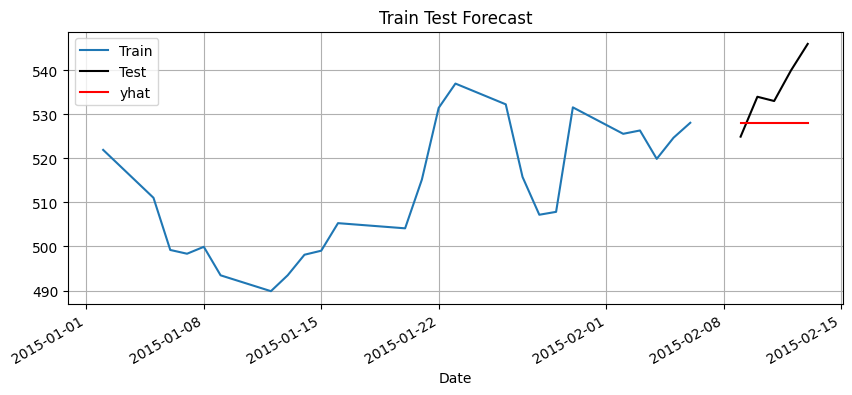

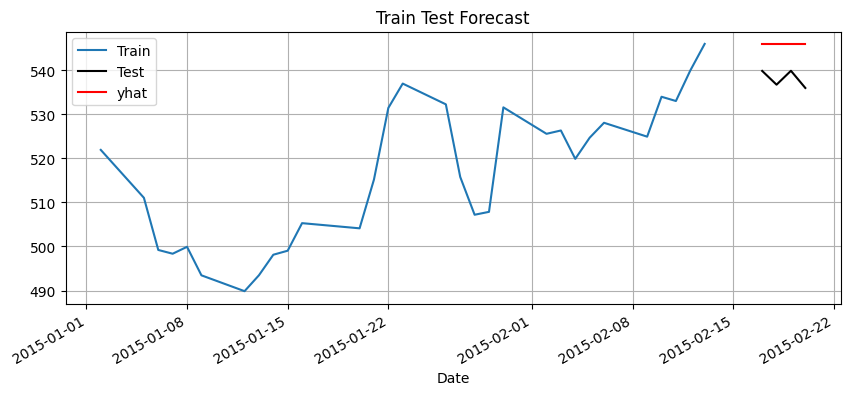

In [221]:
df_metrics = pd.DataFrame()

for i in range(3, df.week.nunique() + 1):

    # Stop on last observation
    if i == df.week.nunique():
        break

    train = df[df["week"] < i].reset_index(drop=True)
    test = df[df["week"] == i].reset_index(drop=True)

    # Naive Method
    yt = train["Close"].iloc[-1]
    test["yhat"] = [yt] * len(test)

    test["resid"] = test["Close"] - test["yhat"]

    dff = metrics(test, "naive", y="Close")
    dff["week"] = i

    df_metrics = pd.concat([df_metrics, dff], axis=0)

    # Plot few plots
    if i < 9:

        fig, ax = plt.subplots(figsize=(10,4))
        train.plot(x="Date", y="Close", label="Train",  ax=ax)
        test.plot(x="Date", y="Close", label="Test", color="k", ax=ax)
        test.plot(x="Date", y="yhat", color="r", ax=ax)

        ax.set_title("Train Test Forecast")
        ax.grid(2)

df_metrics.reset_index(drop=True, inplace=True)

In [222]:
df_metrics.describe().T

,count,mean,std,min,25%,50%,75%,max
MAE,50.0,11.5852,8.348555,2.58,5.9475,9.84,15.4475,54.00
RMSE,50.0,13.4144,10.449559,3.00,7.2225,10.53,17.1775,70.71
MAPE,50.0,1.9104,1.345610,0.48,1.0350,1.57,2.4175,8.74
MASE,50.0,inf,NaN,0.52,1.0700,1.77,7.3650,inf
week,50.0,27.5000,14.577380,3.00,15.2500,27.50,39.7500,52.00


In [223]:
df_metrics

,Method,MAE,RMSE,MAPE,MASE,week
0,naive,5.14,6.42,1.03,0.67,3
1,naive,17.24,21.15,3.25,inf,4
2,naive,18.05,21.15,3.52,52.60,5
3,naive,6.67,7.22,1.27,5.32,6
4,naive,8.76,10.30,1.62,0.83,7
5,naive,7.88,8.07,1.46,inf,8
6,naive,10.10,12.05,1.84,0.77,9
7,naive,13.80,14.04,2.42,7.59,10
8,naive,12.51,14.05,2.28,1.17,11
9,naive,9.27,9.91,1.67,3.19,12
